# Mathematical Engineering - Financial Engineering, FY 2024-2025
<hr>

# Risk Management - Exercise 5: Extended Vasiceck model Monte Carlo simulation for CCR estimation

We import the relevant libraries and the utility files from the first and the fifth lab. Moreover, we also use our `bootstrap_py` package. 

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd


from utilities.ex1_utilities import (
    business_date_offset,
    date_series,
    SwapType,
    year_frac_act_x
)
from utilities.ex5_utilities import (
    affine_trick,
    simulateHW
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

It's convenient to cast the discount factors and the zero rates into a `pd.Series`. We set `today` as the initial date of our bootstrap, $02-Feb-2024$.

In [3]:
from bootstrap_py import Bootstrap, interpolate, yearfrac, DayCount

b = Bootstrap.from_xls("MktData_CurveBootstrap.xls")
dates, discounts = b.fit()

discount_factors = pd.Series(
    discounts, index=dates, name="discount_factors"
)

zero_rates = b.zeroRates()[1]
zero_rates = pd.Series(zero_rates, index=dates[1:], name="zero_rates")

today = b.dates[0]

Here we define the basic parameters of our framework. First, we model the evolution of the stochastic comoponent of the short rate $x_t$ as an Ornstein-Uhlenbeck process

$$
dx(t) = -ax(t)dt + \sigma dW(t)
$$

where $a$ is the mean reversion speed and $\sigma$ the volatility. We are instered in studying the dynamics of an Interest Rate Swap (IRS) Payer, with maturity $T = 8$ years and quarterly payments.

In [4]:
# Parameters
swap_type = SwapType.PAYER # ERROR: it was defined as receiver in the original code
maturity = 8  # Maturity in years
fixed_freq = 4  # Number of times per year

mean_reversion_speed = 0.0195
sigma = 0.0086

expiry = business_date_offset(today, year_offset=maturity)
fixed_leg_payment_dates = date_series(today, expiry, fixed_freq)
fixed_leg_payment_dates = [business_date_offset(date) for date in fixed_leg_payment_dates]

disc_inter = [
    interpolate(discounts, dates, target)
    for target in fixed_leg_payment_dates
]
yf = [
    yearfrac(prev, next, DayCount.EU_30_360)
    for prev, next in zip(fixed_leg_payment_dates[:-1], fixed_leg_payment_dates[1:])
]

disc_inter = pd.Series(disc_inter, index=fixed_leg_payment_dates, name="discount_factors")

With these basic quantities we can compute the swap rate $S$ of the contract

In [5]:

BPV = sum([df* yf_ for df, yf_ in zip(disc_inter, yf)])
swap_rate = (1-discount_factors[expiry])/BPV

print(f"Swap rate: {swap_rate:.4%}")

Swap rate: 2.7693%


We'll study how the value of the swap and the corresponding risk metrics evolve through time using a Monte Carlo simulation on $x_t$, according to the mean-reverting dynamics written above. We run a simulation with $N = 250000$ samples. Thanks to an efficient use of vectorization and built-in `numpy` features, the simulation runs smoothly in a few seconds

In [6]:
# Monte Carlo Simulations
simulations_num = 250_000
simulation_grid = fixed_leg_payment_dates[1:]

alpha = 0.95  # PFE confidence level

expected_exposure = pd.DataFrame(
    data=0.0, index=simulation_grid, columns=["no_collateral", "collateral"]
)
potential_future_exposure = pd.DataFrame(
    data=0.0, index=simulation_grid, columns=["no_collateral", "collateral"]
)

In [7]:
irs_cash_flows = pd.Series([swap_rate* yf_ for yf_ in yf], index=fixed_leg_payment_dates[1:])

The Hull-White model leads and to affine term structure, such that the discount factor can be written as 

$$
P(t,T) = A(t,T) \exp\Big\{C(t,T)(T-t)\Big\}
$$

In [8]:
A,C = affine_trick(
    simulation_grid[0],
    simulation_grid,
    mean_reversion_speed,
    sigma,
    disc_inter
)

This cell may take a few seconds to run, as we're simulating $N=250000$ different scenarions for $32$ simulation dates.

In [9]:
np.random.seed(42)
Z = np.random.normal(size=(simulations_num, len(simulation_grid)))

MtMs = np.zeros((simulations_num, len(simulation_grid)))

collateral = np.zeros((simulations_num, 9))

years = date_series(today, expiry, 1)
disc_inter_years = [
    interpolate(discounts, dates, target)
    for target in years
]


for count, sim_date in enumerate(simulation_grid):
    if count == 0:
        prev_sim_date = today
        x_t = np.zeros((1, simulations_num))

    else:
        prev_sim_date = simulation_grid[count - 1]

    # !!! SIMULATE THE SHORT RATE !!!
    x_t = simulateHW(Z[:,count], mean_reversion_speed, sigma, x_t, prev_sim_date, sim_date)

    A, C = affine_trick(
        sim_date,
        simulation_grid,
        mean_reversion_speed,
        sigma,
        disc_inter,
    )

    # Simulated MtM
    MtM = (1 if swap_type == SwapType.RECEIVER else -1) * (
        np.sum(
            np.exp(
                np.log(irs_cash_flows * A).values.reshape(-1, 1)
                @ np.ones((1, simulations_num))
                - C.values.reshape(-1, 1) @ x_t.reshape(1, -1)
            ),
            axis=0,
        )
        + A.iloc[-1]*np.exp(-x_t*C.iloc[-1])
        - (1 if sim_date < simulation_grid[-1] else 0)
    )[0]
    MtMs[:,count] = MtM

    MtM_coll = MtM
    if (count+1) % 4 == 0:
        for i in range(len(years[:(count+1)//4])):
            fwd_disc=disc_inter_years[(count+1)//4]/disc_inter_years[i]
            MtM_coll = MtM_coll + collateral[:,i]/fwd_disc
            collateral[:,(count+1)//4]= - MtM_coll
        # the MtM is zero because of collateral exchange
        MtM_coll = 1e-5 # to avoid division by zero
    else:
        for i in range(len(collateral[:count//4])):
            fwd_disc=disc_inter[count]/disc_inter_years[i]
            MtM_coll = MtM_coll + collateral[:,i]/fwd_disc

    # print(f"mean MtM: {np.mean(MtM)}")
    CE = np.maximum(0, MtM)
    CE_coll = np.maximum(0, MtM_coll)
    prob = np.mean(MtM > 0)
    prob_coll = np.mean(MtM_coll > 0)

    # !!! COMPUTE THE EXPECTED EXPOSURE !!!
    expected_exposure.loc[sim_date, "no_collateral"] = np.mean(CE)/prob
    expected_exposure.loc[sim_date, "collateral"] = np.mean(CE_coll)/prob_coll

    # !!! COMPUTE THE POTENTIAL FUTURE EXPOSURE !!!
    potential_future_exposure.loc[sim_date, "no_collateral"] = np.quantile(MtM, 0.95)
    potential_future_exposure.loc[sim_date, "collateral"] = np.quantile(MtM_coll, 0.95)

# !!! COMPUTE THE EXPECTED POSITIVE EXPOSURE AND THE PEAK-PFE!!!
expected_positive_exposure = np.mean(expected_exposure, axis=0)
peak_pfe = np.max(potential_future_exposure, axis=0)

In [10]:
expected_positive_exposure

no_collateral    0.036022
collateral       0.024758
dtype: float64

In [11]:
peak_pfe

no_collateral    0.099072
collateral       0.091226
dtype: float64

In [12]:
import matplotlib.pyplot as plt

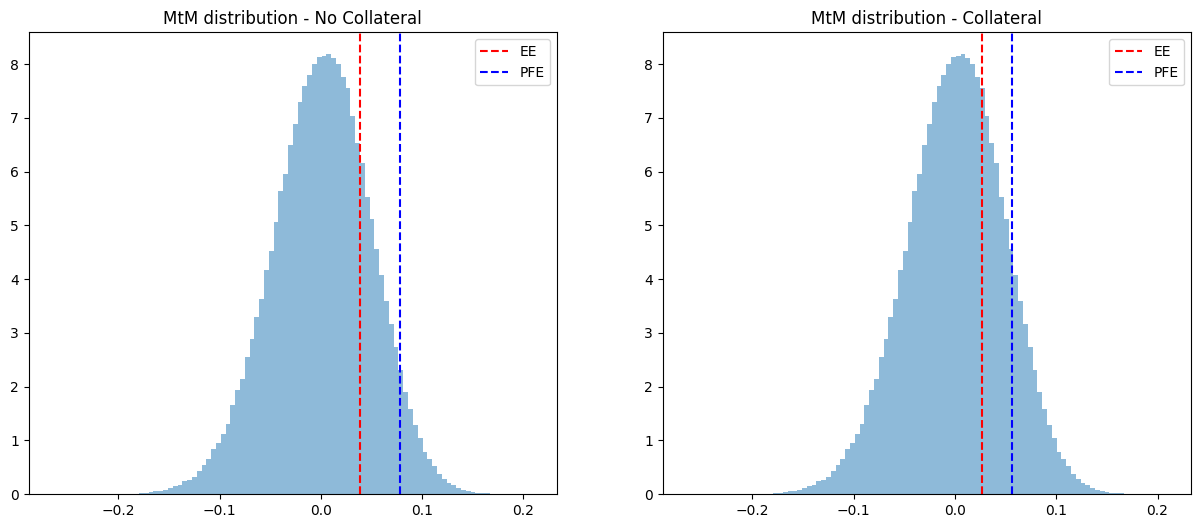

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].hist(MtMs[:,20], bins=100, density=True, alpha=0.5)
ax[0].axvline(x=expected_exposure["no_collateral"].iloc[20], color="red", linestyle="--", label="EE")
ax[0].axvline(x=potential_future_exposure["no_collateral"].iloc[20], color="blue", linestyle="--", label="PFE")
ax[0].set_title("MtM distribution - No Collateral")
ax[0].legend()

ax[1].hist(MtMs[:,20], bins=100, density=True, alpha=0.5)
ax[1].axvline(x=expected_exposure["collateral"].iloc[20], color="red", linestyle="--", label="EE")
ax[1].axvline(x=potential_future_exposure["collateral"].iloc[20], color="blue", linestyle="--", label="PFE")
ax[1].set_title("MtM distribution - Collateral")
ax[1].legend()

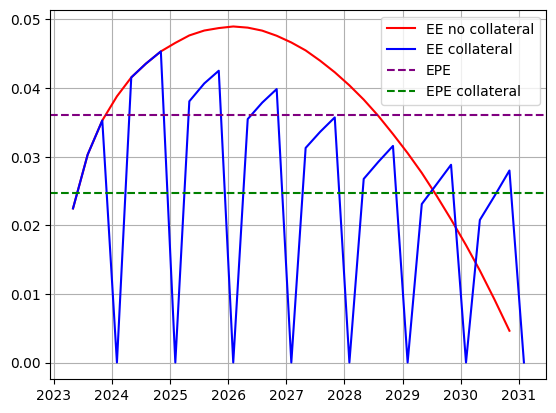

In [14]:
plt.plot(
    expected_exposure.index,
    expected_exposure["no_collateral"],
    label="EE no collateral",
    color="red",
)
plt.plot(
    expected_exposure.index,
    expected_exposure["collateral"],
    label="EE collateral",
    color="blue",
)
plt.grid()
plt.axhline(expected_positive_exposure["no_collateral"], color="purple", linestyle="--", label="EPE")
plt.axhline(expected_positive_exposure["collateral"], color="green", linestyle="--", label="EPE collateral")
plt.legend()